# PPCA in TensorFlow Probability
This is the ZIFA method (Pierson, 2015)

First we import necessary libraries

In [193]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

We create a function of the ZIFA model:

In [194]:
Root = tfd.JointDistributionCoroutine.Root
def ZIFA(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    
    # We start by generating a sigma^2
    sigma_sqrd = yield Root(tfd.Independent(
        tfd.Normal(loc=stddv_datapoints, scale=0.05, name='sigma')))
    
    # We initialize lambda here
    lamda = yield Root(tfd.Independent(
        tfd.Normal(loc=0.1, scale=0.03, name='lambda')))
    
    # Then the latent data z
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=1.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))

    # For A we first define the boundaries for its uniform distribution and then A itself
    low_A = np.float32(-0.5*np.ones([data_dim, latent_dim]))
    np.fill_diagonal(low_A,0.9*sigma_sqrd)
    high_A = np.float32(0.5*np.ones([data_dim, latent_dim]))
    np.fill_diagonal(high_A,1.1*sigma_sqrd)
    
    A = yield Root(tfd.Independent(
        tfd.Uniform(low=low_A, high=high_A, name='A')))
    
    # Here comes mu
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=3*tf.ones([data_dim,1]),
                 scale=2.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    
    # We compute Az to be the mean of x
    x_mean = np.float32(np.zeros((data_dim, num_datapoints)))
    for sample in range(num_datapoints):
        x_mean[:,sample] = tf.squeeze(tf.matmul(A,tf.expand_dims(z[:,sample],-1))+mu)
    
    # the computed means are given to a normal distribution to generate observed data x
    x = yield tfd.Independent(tfd.Normal(
        loc=x_mean,
        scale=sigma_sqrd,
        name="x"), reinterpreted_batch_ndims=2)
    
    # Bernoulli variable h is generated based on x and lambda
    h = yield tfd.Independent(tfd.Bernoulli(
    probs = 1-tf.exp(tf.multiply(-lamda,tf.square(x))), name = 'h',dtype=tf.float32,))
    
    # Then the final points y can be generated
    y = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.multiply(h,x),
                 scale=0,
                 name="y"), reinterpreted_batch_ndims=2))

num_datapoints = 500
data_dim = 3
latent_dim = 2
stddv_datapoints = 0.3

concrete_ZIFA_model = functools.partial(ZIFA,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutine(concrete_ZIFA_model)

And we generate some data. Note the Zero inflation as depicted in the two histograms representing two genes.

Lambda:  tf.Tensor(0.040047176, shape=(), dtype=float32)
mu: tf.Tensor(
[[4.7223086]
 [3.1667309]
 [3.5658717]], shape=(3, 1), dtype=float32)


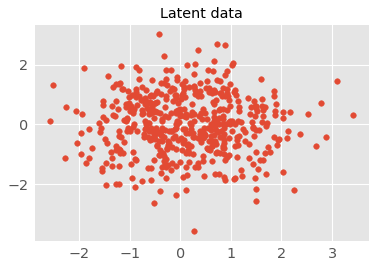

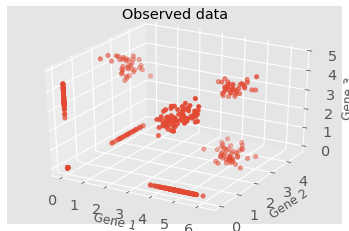

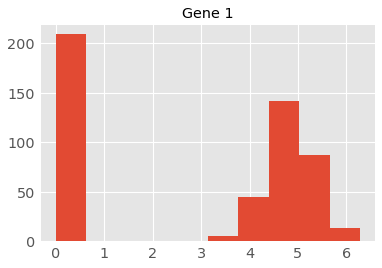

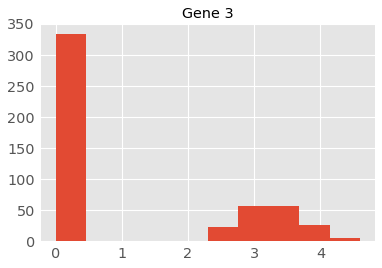

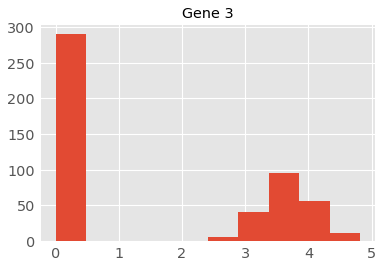

In [216]:
actual_sigma, actual_lambda, actual_z, actual_A, actual_mu, actual_x, actual_h, y_train = model.sample()
print('Lambda: ', actual_lambda)
print('mu:', actual_mu)

# print("Principal axes:")
# print(actual_w)
# print(actual_z)

plt.scatter(actual_z[0,:], actual_z[1,:])
title = plt.title('Latent data')
plt.setp(title, color='black') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:])
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y_train[0, :])
title = plt.title('Gene 1')
plt.setp(title, color='black')
plt.show()
plt.hist(y_train[1, :])
title = plt.title('Gene 3')
plt.setp(title, color='black')
plt.show()
plt.hist(y_train[2, :])
title = plt.title('Gene 3')
plt.setp(title, color='black')
plt.show()

Then we minimize the error numerically:

In [213]:
def ZIFA_step1(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    
    # We start by generating a sigma^2
    sigma_sqrd = yield Root(tfd.Independent(
        tfd.Normal(loc=stddv_datapoints, scale=0.05, name='sigma')))

    # Then the latent data z
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=1.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))

    # For A we first define the boundaries for its uniform distribution and then A itself
    low_A = np.float32(-0.5*np.ones([data_dim, latent_dim]))
    np.fill_diagonal(low_A,0.9*sigma_sqrd)
    high_A = np.float32(0.5*np.ones([data_dim, latent_dim]))
    np.fill_diagonal(high_A,1.1*sigma_sqrd)
    
    A = yield Root(tfd.Independent(
        tfd.Uniform(low=low_A, high=high_A, name='A')))
    
    # Here comes mu
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=3*tf.ones([data_dim,1]),
                 scale=2.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    
    # We compute Az to be the mean of x
    x_mean = np.float32(np.zeros((data_dim, num_datapoints)))
    for sample in range(num_datapoints):
        x_mean[:,sample] = tf.squeeze(tf.matmul(A,tf.expand_dims(z[:,sample],-1))+mu)
    
    # the computed means are given to a normal distribution to generate observed data x
    x = yield tfd.Independent(tfd.Normal(
        loc=x_mean,
        scale=sigma_sqrd,
        name="x"), reinterpreted_batch_ndims=2)
    
ZIFA_model_1 = functools.partial(ZIFA_step1,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_1 = tfd.JointDistributionCoroutine(ZIFA_model_1)

According to Pierson (2015), $\mu$ and $A$ should be optimized first, followed by $\sigma^2$ and ending with $\lambda$. We first optimize $\mu$ by initializing it as the mean of our observed data. We then optimalize on a separate model that doesn't contain $\lambda$, followed by the complete model.

In [214]:
mu = tf.expand_dims(tf.reduce_mean(y_train, 1),1)

sigma = 1.0
A = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
# h = tf.Variable(np.ones([data_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda sigma, z, A, mu: model_1.log_prob((sigma, z, A, mu, y_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, z, A, mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()
# print(losses)

target_log_prob_fn = lambda w, z, mu, h: model.log_prob((w, z, mu, h, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(w, z, mu, h),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()
# print(losses)

TypeError: __array__() takes 1 positional argument but 2 were given

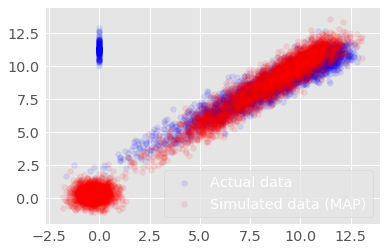

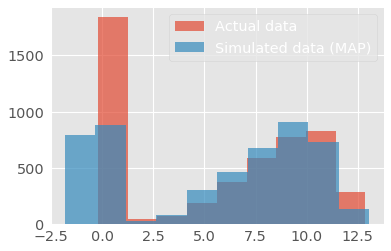

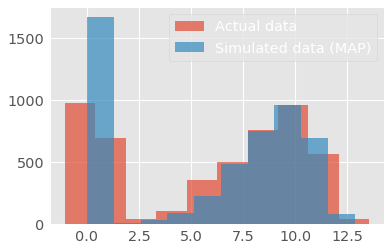

In [7]:
_, _, _, _, x_generated = model.sample(value=(w, z, mu, h, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
# plt.axis([-20, 20, -20, 20])
plt.show()
plt.hist(x_train[0, :], alpha=0.7, label='Actual data')
plt.hist(x_generated[0, :], alpha=0.7, label='Simulated data (MAP)')
plt.legend()
plt.show()
plt.hist(x_generated[1, :], alpha=0.7, label='Actual data')
plt.hist(x_train[1, :], alpha=0.7, label='Simulated data (MAP)')
plt.legend()
plt.show()